## Table of Contents
 * [Loading packages and data](#loading_packages_and)
	 * [Preliminary analysis](#preliminary_analysis)
	 * [Effect of treatment (i.e. showing `ad`)](#effect_of_treatment)
	 * [Effect of 'Most watch day'](#effect_of_'most)
	 * [Effect of 'most ads hour'](#effect_of_'most_0)
	 * [Simple logistic regression estimation](#simple_logistic_regression)
 * [Bayesian modeling](#bayesian_modeling)
	 * [Modeling day and hour influence (without interaction)](#modeling_day_and)
	 * [Model discription](#model_discription)
	 * [Checking model posterior predictivity](#checking_model_posterior)
	 * [Checking if the model confirms preliminary findings](#checking_if_the)
	 * [Which combination `(group, day, section)` has highest convertion rate?](#which_combination_`(group,)
	 * [Conclusions](#conclusions)
	 * [Interaction Model](#interaction_model)
		 * [Model discription](#model_discription_0)
 * [Conclusions](#conclusions_0)
	 * [Interaction Free](#interaction_free)
	 * [Interaction](#interaction)

# Loading packages and data <a class="anchor" id="loading_packages_and"></a>


In [6]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import scipy as sp
import statsmodels.formula.api as smf
from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt  
import seaborn as sns
sns.set_theme()

In [2]:
df = pd.read_csv('./Project/data/marketing_AB.csv')
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [3]:
# renaming the columns with '_' instead of spaces
df = df.rename(columns={
    'test group': 'test_group',
    'total ads': 'total_ads',
    'most ads day': 'most_ads_day',
    'most ads hour': 'most_ads_hour'
})

In [92]:
# ensuring correct data types
df['converted'] = df['converted'].astype(bool)
df['test_group'] = df['test_group'].astype('category')
df['most_ads_day'] = df['most_ads_day'].astype('category')

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   Unnamed: 0     588101 non-null  int64   
 1   user id        588101 non-null  int64   
 2   test_group     588101 non-null  category
 3   converted      588101 non-null  bool    
 4   total_ads      588101 non-null  int64   
 5   most_ads_day   588101 non-null  category
 6   most_ads_hour  588101 non-null  int64   
 7   section        588101 non-null  object  
dtypes: bool(1), category(2), int64(4), object(1)
memory usage: 24.1+ MB


## Preliminary analysis <a class="anchor" id="preliminary_analysis"></a>
Frquentist approach to see how each features influence the conversion rate 

## Effect of treatment (i.e. showing `ad`) <a class="anchor" id="effect_of_treatment"></a>
Note 'control' group is the group which is shown `psa`

In [7]:
# Aggregate conversion rate by test group
group_summary = df.groupby('test_group')['converted'].agg(['mean', 'count'])
print(group_summary)
print(f"The ratio of people coverted in the treatment group is {group_summary.loc['ad']['mean']: .4f}")
print(f"Compared to psa group which is {group_summary.loc['psa']['mean']:.4f}")
print("This shows there is higher chance of conversion when ad showed")
print(f"The lift ((P(ad|treatment) - P(psa|control)) / P(psa|control)) is:\
      {(group_summary.loc['ad']['mean'] - group_summary.loc['psa']['mean']) / group_summary.loc['psa']['mean'] * 100 : 0.2f} %")



                mean   count
test_group                  
ad          0.025547  564577
psa         0.017854   23524
The ratio of people coverted in the treatment group is  0.0255
Compared to psa group which is 0.0179
This shows there is higher chance of conversion when ad showed
The lift ((P(ad|treatment) - P(psa|control)) / P(psa|control)) is:       43.09 %


/var/folders/rn/n58cg6xx22lf00fqznzx3_vh0000gn/T/ipykernel_96695/3081701928.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_summary = df.groupby('test_group')['converted'].agg(['mean', 'count'])


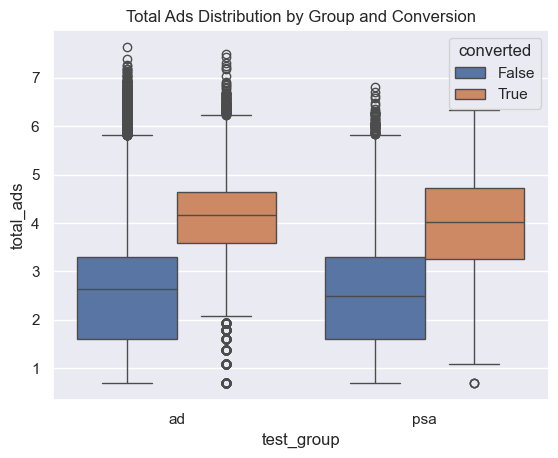

In [9]:
# Taking log(1+y) to see the differences more clearly
sns.boxplot(x='test_group', y=np.log1p(df['total_ads']), hue='converted', data=df)
plt.title('Total Ads Distribution by Group and Conversion')
plt.show()

## Effect of 'Most watch day' <a class="anchor" id="effect_of_'most"></a>


/var/folders/rn/n58cg6xx22lf00fqznzx3_vh0000gn/T/ipykernel_96695/3270907757.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  day_conv = df.groupby(['most_ads_day', 'test_group'])['converted'].mean().unstack()


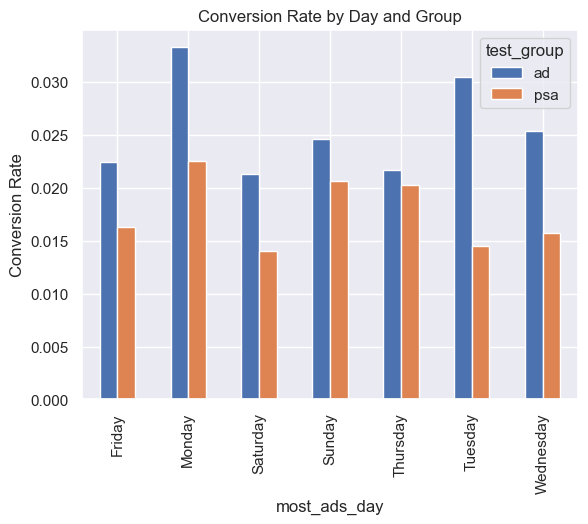

In [10]:
day_conv = df.groupby(['most_ads_day', 'test_group'])['converted'].mean().unstack()
day_conv.plot(kind='bar')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Day and Group')
plt.show()


In [11]:
day_summary = df.groupby(['most_ads_day', 'test_group'])['converted'].agg(['mean', 'count'])
day_summary_unstacked = day_summary.unstack('test_group')
day_summary_unstacked['lift']=(day_summary_unstacked['mean', 'ad'] - day_summary_unstacked['mean', 'psa'] ) / day_summary_unstacked['mean', 'psa'] 
day_summary_unstacked


/var/folders/rn/n58cg6xx22lf00fqznzx3_vh0000gn/T/ipykernel_96695/4048238062.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  day_summary = df.groupby(['most_ads_day', 'test_group'])['converted'].agg(['mean', 'count'])


mean            count            lift
test_group          ad       psa     ad   psa          
most_ads_day                                           
Friday        0.022465  0.016303  88805  3803  0.377971
Monday        0.033241  0.022559  83571  3502  0.473553
Saturday      0.021307  0.013996  78802  2858  0.522354
Sunday        0.024620  0.020595  82332  3059  0.195430
Thursday      0.021637  0.020230  79077  3905  0.069532
Tuesday       0.030440  0.014448  74572  2907  1.106909
Wednesday     0.025356  0.015759  77418  3490  0.608945

Some qualitative remarks:
1. Shows that some days (Monday) the conversion rate is higher compared to other for both groups.
2. Shows treatment as much higher on higher lift for some days (Tuesday, Saturday) compared to others

## Effect of 'most ads hour' <a class="anchor" id="effect_of_'most_0"></a>


1. Similar analysis for the hours as well. But let me simplifyy by grouping into 4 divisions in a day as follows

In [12]:
# Define sections of the day
def get_section(hour):
    if 2 <= hour <= 8:
        return '2-8'
    elif 9 <= hour <= 14:
        return '9-14'
    elif 15 <= hour <= 20:
        return '15-20'
    else:
        # Covers 21-23, 0-1 hours
        return '21-1'

df['section'] = df['most_ads_hour'].apply(get_section)

/var/folders/rn/n58cg6xx22lf00fqznzx3_vh0000gn/T/ipykernel_96695/3358062032.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  section_conv = df.groupby(['section', 'test_group'])['converted'].mean().unstack()


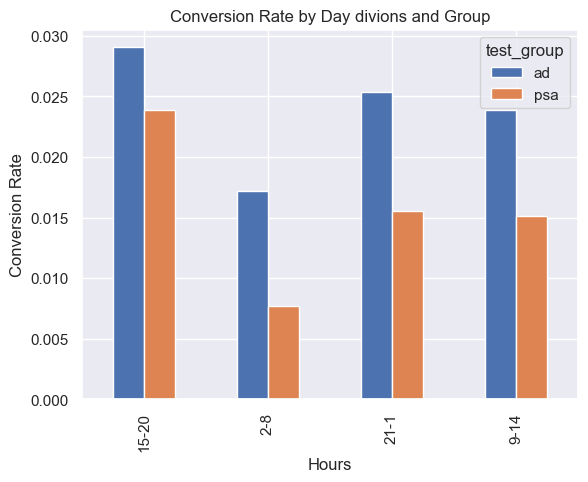

In [13]:
section_conv = df.groupby(['section', 'test_group'])['converted'].mean().unstack()
section_conv.plot(kind='bar')
plt.ylabel('Conversion Rate')
plt.xlabel('Hours')
plt.title('Conversion Rate by Day divions and Group')
plt.show()

In [14]:
hour_summary = df.groupby(['most_ads_hour', 'test_group'])['converted'].agg(['mean', 'count'])
hour_summary_unstacked = hour_summary.unstack('test_group')
hour_summary_unstacked['lift']=(hour_summary_unstacked['mean', 'ad'] - hour_summary_unstacked['mean', 'psa'] ) / hour_summary_unstacked['mean', 'psa'] 
hour_summary_unstacked

/var/folders/rn/n58cg6xx22lf00fqznzx3_vh0000gn/T/ipykernel_96695/1677575962.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hour_summary = df.groupby(['most_ads_hour', 'test_group'])['converted'].agg(['mean', 'count'])


mean            count            lift
test_group           ad       psa     ad   psa          
most_ads_hour                                           
0              0.019213  0.000000   5309   227       inf
1              0.013434  0.000000   4615   187       inf
2              0.007570  0.000000   5152   181       inf
3              0.010425  0.011236   2590    89 -0.072201
4              0.015850  0.000000    694    28       inf
5              0.021563  0.000000    742    23       inf
6              0.023174  0.000000   1985    83       inf
7              0.018482  0.008439   6168   237  1.190175
8              0.019861  0.010622  16968   659  0.869763
9              0.019529  0.010815  29802  1202  0.805671
10             0.021840  0.013468  37454  1485  0.621629
11             0.022469  0.014556  44149  2061  0.543645
12             0.024139  0.016990  45238  2060  0.420752
13             0.025063  0.016590  45485  2170  0.510754
14             0.028575  0.016051  43779  1869  0.780244
15             0.029845  0.025164  42855  1828  0.186007
16             0.030893  0.028055  35963  1604  0.101159
17             0.028537  0.020246  33605  1383  0.409545
18             0.027470  0.025177  31052  1271  0.091076
19             0.026809  0.024514  29169  1183  0.093634
20             0.030274  0.017642  27846  1077  0.716038
21             0.029175  0.022202  28895  1081  0.314073
22             0.026455  0.016358  25515   917  0.617284
23             0.022970  0.012924  19547   619  0.777325

In [15]:
section_summary = df.groupby(['section', 'test_group'])['converted'].agg(['mean', 'count'])
section_summary_unstacked = section_summary.unstack('test_group')
section_summary_unstacked['lift']=(section_summary_unstacked['mean', 'ad'] - section_summary_unstacked['mean', 'psa'] ) / section_summary_unstacked['mean', 'psa'] 
section_summary_unstacked

/var/folders/rn/n58cg6xx22lf00fqznzx3_vh0000gn/T/ipykernel_96695/1025030850.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  section_summary = df.groupby(['section', 'test_group'])['converted'].agg(['mean', 'count'])


mean             count             lift
test_group        ad       psa      ad    psa          
section                                                
15-20       0.029064  0.023844  200490   8346  0.218927
2-8         0.017202  0.007692   34299   1300  1.236217
21-1        0.025405  0.015506   83881   3031  0.638355
9-14        0.023891  0.015119  245907  10847  0.580166

Some remarks:
1. It appears that some hours (late afternoon or night time) are more effective compared to other for both the groups.
2. However, the `lift` seems to be much higher for the off-hours such as morning hours 7-11). But this could be an artifact of very few users in both the groups.

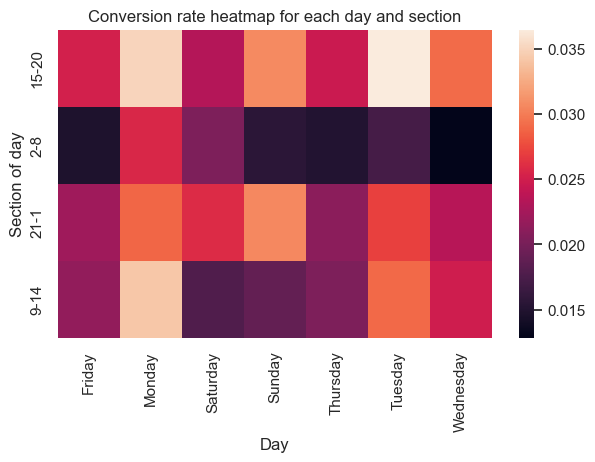

In [60]:
tmp = df.groupby(['section', 'most_ads_day'], sort=True)['converted'].apply(lambda x: sum(x)/len(x)).unstack()

plt.figure(figsize=(7,4))
sns.heatmap(data=tmp1)
plt.xlabel('Day')
plt.ylabel('Section of day')
plt.title('Conversion rate heatmap for each day and section')
plt.show()

In [83]:
lift_tmp

most_ads_day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
section,,,,,,,
15-20,0.114834,0.261860,0.554891,-0.068090,0.039972,0.691652,0.301253
2-8,0.761005,NaN,0.795524,1.285118,0.036706,1.609300,NaN
21-1,0.092584,3.542429,1.322744,1.212594,-0.138426,0.431916,0.985284
9-14,0.822866,0.317854,0.239814,0.347899,0.184330,1.734070,1.039727


In [86]:

tmp1 = df[df['test_group']=='ad'].groupby(['section', 'most_ads_day'], sort=True)['converted'].apply(lambda x: sum(x)/len(x)).unstack()
tmp2 = df[df['test_group']=='psa'].groupby(['section', 'most_ads_day'], sort=True)['converted'].apply(lambda x: sum(x)/len(x)).unstack()

lift_tmp = 100 * (tmp1 - tmp2) / tmp2
lift_tmp = lift_tmp.replace([np.inf, -np.inf], np.nan)
lift_tmp

most_ads_day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
section,,,,,,,
15-20,11.483423,26.186045,55.489088,-6.808959,3.997154,69.165160,30.125309
2-8,76.100510,NaN,79.552435,128.511848,3.670597,160.930030,NaN
21-1,9.258402,354.242901,132.274423,121.259403,-13.842597,43.191614,98.528422
9-14,82.286644,31.785392,23.981392,34.789857,18.432996,173.407025,103.972695


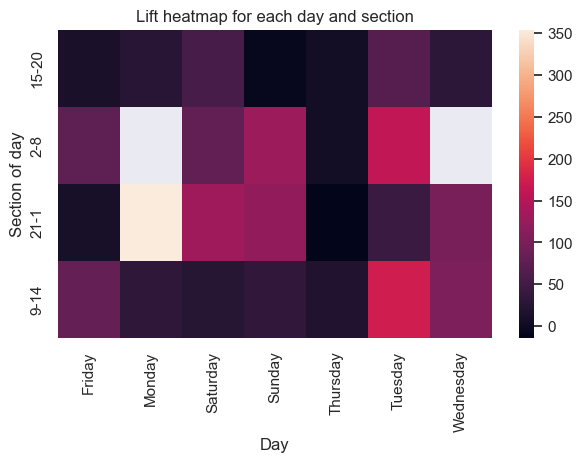

In [85]:

plt.figure(figsize=(7,4))
sns.heatmap(data=lift_tmp)
plt.xlabel('Day')
plt.ylabel('Section of day')
plt.title('Lift heatmap for each day and section')
plt.show()

## Simple logistic regression estimation <a class="anchor" id="simple_logistic_regression"></a>


In [94]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   Unnamed: 0     588101 non-null  int64   
 1   user id        588101 non-null  int64   
 2   test_group     588101 non-null  category
 3   converted      588101 non-null  bool    
 4   total_ads      588101 non-null  int64   
 5   most_ads_day   588101 non-null  category
 6   most_ads_hour  588101 non-null  int64   
 7   section        588101 non-null  object  
dtypes: bool(1), category(2), int64(4), object(1)
memory usage: 24.1+ MB


,Unnamed: 0,user id,test_group,converted,total_ads,most_ads_day,most_ads_hour,section
0,0,1069124,ad,False,130,Monday,20,15-20
1,1,1119715,ad,False,93,Tuesday,22,21-1
2,2,1144181,ad,False,21,Tuesday,18,15-20
3,3,1435133,ad,False,355,Tuesday,10,9-14
4,4,1015700,ad,False,276,Friday,14,9-14


In [95]:
df['converted']=df['converted'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   Unnamed: 0     588101 non-null  int64   
 1   user id        588101 non-null  int64   
 2   test_group     588101 non-null  category
 3   converted      588101 non-null  int64   
 4   total_ads      588101 non-null  int64   
 5   most_ads_day   588101 non-null  category
 6   most_ads_hour  588101 non-null  int64   
 7   section        588101 non-null  object  
dtypes: category(2), int64(5), object(1)
memory usage: 28.0+ MB


In [96]:
model = smf.logit('converted ~ C(test_group) + total_ads + C(most_ads_day)+ C(most_ads_hour)', data=df)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.108125
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               588101
Model:                          Logit   Df Residuals:                   588069
Method:                           MLE   Df Model:                           31
Date:                Wed, 10 Sep 2025   Pseudo R-squ.:                 0.08198
Time:                        13:23:59   Log-Likelihood:                -63588.
converged:                       True   LL-Null:                       -69267.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -4.5602      0.106    -43.120      0.000

In [101]:
pred_probs = result.predict()
pred_class = (pred_probs >=0.3).astype(int)
true_classes = df['converted'].astype(int) 

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

acc = accuracy_score(true_classes, pred_class)
cm = confusion_matrix(true_classes, pred_class)
roc_auc = roc_auc_score(true_classes, pred_probs)

print(f'Accuracy: {acc:.3f}')
print('Confusion Matrix:\n', cm)
print(f'ROC AUC: {roc_auc:.3f}')

Accuracy: 0.972
Confusion Matrix:
 [[571459   1799]
 [ 14478    365]]
ROC AUC: 0.815


Conclusions
Test group matters: The "ad" group has higher conversion odds than "psa".

Day of highest ads significantly impacts conversion rates, with some days better than baseline, especially Monday and Tuesday.

Total ads seen positively influence the chance of conversion, though the effect per ad is small but statistically significant due to large sample size.

The model fits better than null but explains only a modest fraction of variance (pseudo R-squared ~ 0.078)

# Bayesian modeling <a class="anchor" id="bayesian_modeling"></a>


1. Despite having half a million samples, actual conversions are rare—especially when data is split by day and hour. This issue is even more pronounced for the control group, which only makes up about 10% of the total, resulting in very few control conversions in many slots.

2. Bayesian hierarchical modeling is crucial in this setting, since it can "borrow strength" across groups, days, and hours, producing reliable estimates and solid conclusions even for categories with limited data.
To better quantify uncertainty and hierarchical/group-specific effects (e.g., separate effects per group/day).

3. To model potential interactions (e.g., ad effect varying by day and group or other similar combinations).

4. To include random effects or non-linear terms for better flexibility

5. Although effects are clear, Bayesian modeling can better quantify uncertainty, incorporate hierarchical structure (group/day effects), and model any interactions that would have on each other features.

6. It offers richer inference and posterior distributions for prediction and decision making under uncertainty.

## Modeling day and hour influence (without interaction) <a class="anchor" id="modeling_day_and"></a>
1. For this initial model, I will focus on the influence of `most_ads_day` and `section` while accounting for the `total_ads` as only a mean of the particular group.
2. This is not the complete model, but it is still rich enough to give some insights about the influence of features other than `total_ads`
3. Main reason for this simplifications is that this model is much faster since it effectively reduces to 56 rows = (2 groups * 7 days * 4 sections), while the full model contains a quarter of a million rows!

In [21]:
# aggregating by group, day, and section
agg = df.groupby(['test_group', 'most_ads_day', 'section']).agg(
    n=('user id', 'count'),
    k=('converted', 'sum'),
    mean_total_ads=('total_ads', 'mean')
).reset_index()
agg

/var/folders/rn/n58cg6xx22lf00fqznzx3_vh0000gn/T/ipykernel_96695/2439159020.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby(['test_group', 'most_ads_day', 'section']).agg(


,test_group,most_ads_day,section,n,k,mean_total_ads
0,ad,Friday,15-20,31097,783,26.571180
1,ad,Friday,2-8,5293,78,31.276592
2,ad,Friday,21-1,15116,335,26.916248
3,ad,Friday,9-14,37299,799,26.028821
4,ad,Monday,15-20,31435,1101,26.355273
5,ad,Monday,2-8,4639,119,26.127829
6,ad,Monday,21-1,12079,348,20.421392
7,ad,Monday,9-14,35418,1210,26.130583
8,ad,Saturday,15-20,29348,683,23.958225
9,ad,Saturday,2-8,4558,93,34.513164


In [22]:

# Factorize categorical variables to create indices for PyMC
agg['group_idx'], unique_groups = pd.factorize(agg['test_group'])
agg['day_idx'], unique_days = pd.factorize(agg['most_ads_day'])
agg['section_idx'], unique_sections = pd.factorize(agg['section'])
agg.head()

,test_group,most_ads_day,section,n,k,mean_total_ads,group_idx,day_idx,section_idx
0,ad,Friday,15-20,31097,783,26.571180,0,0,0
1,ad,Friday,2-8,5293,78,31.276592,0,0,1
2,ad,Friday,21-1,15116,335,26.916248,0,0,2
3,ad,Friday,9-14,37299,799,26.028821,0,0,3
4,ad,Monday,15-20,31435,1101,26.355273,0,1,0


In [23]:
agg_data = agg.copy()

In [103]:
# The formula predicts 'k' (number of successes) using possible predictors.
# Add offset=np.log(n) if 'n' is the number of trials, so model predicts rates.
formula = "k ~ C(test_group) + C(most_ads_day) + C(section) + mean_total_ads"

# If you want to model rate (successes per trial), include offset
model_new = smf.poisson(formula, data=agg_data, offset=np.log(agg_data['n']))

result_new = model_new.fit()
print(result_new.summary())


Optimization terminated successfully.
         Current function value: 3.976099
         Iterations 5
                          Poisson Regression Results                          
Dep. Variable:                      k   No. Observations:                   56
Model:                        Poisson   Df Residuals:                       44
Method:                           MLE   Df Model:                           11
Date:                Wed, 10 Sep 2025   Pseudo R-squ.:                  0.6279
Time:                        16:34:38   Log-Likelihood:                -222.66
converged:                       True   LL-Null:                       -598.33
Covariance Type:            nonrobust   LLR p-value:                5.296e-154
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -4.9390      0.169    -29.256      0.000

## Model discription <a class="anchor" id="model_discription"></a>
Aggregate data has basically 56 groups or cells defined by unique combination of `(group, day, section)`
* `i` index the cells in aggregated data
* `k_i` is the number of conversion for each cell
* `n_i` is total number of users in cell `i`
* `x_i` is the average of `total_ads` for cell `i`
Then model the conversion counts 
`k_i` ~ Binomial(n_i, p_i) ,

where `p_i` is defined as

$$ z_i = \alpha^{group[i]} + \beta^{day[i]} + \gamma^{section[i]} + \theta * x_i$$

$$p_i = sigmoid(z_i)$$


Here $\alpha^{group[i]}, \beta^{day[i]}, \gamma^{section[i]} + \theta $ are the regression coefficients that model the effects of group, day, and section respectively.

And $\theta$ model the effects of mean total ads



In [24]:
# COORDS definition based on unique group/day/section
COORDS = {
    "group": unique_groups,
    "day": unique_days,
    "section": unique_sections,
    "cell": np.arange(len(agg_data)),
}

with pm.Model(coords=COORDS) as model:
    # Hyperpriors for group/day/section effects
    sigma_group = pm.HalfNormal("sigma_group", 1)
    sigma_day = pm.HalfNormal("sigma_day", 1)
    sigma_section = pm.HalfNormal("sigma_section", 1)

    # Partial pooling of intercepts    
    mu_base = pm.Normal("mu_base", mu=0, sigma=50)
    sigma_base = pm.HalfNormal("sigma_base", sigma=10)
    delta = pm.Normal("delta", mu=mu_base, sigma=sigma_base)
    alpha = pm.Normal("alpha", mu=0, sigma=sigma_group, dims="group")
    beta = pm.Normal("beta", mu=0, sigma=sigma_day, dims="day")
    gamma = pm.Normal("gamma", mu=0, sigma=sigma_section, dims="section")

    # Regression coefficient for mean total_ads (continuous)
    theta = pm.Normal("theta", mu=0, sigma=1)

    # Data inputs aligned with cells
    group_idx = pm.Data("group_idx", agg_data["group_idx"], dims="cell")
    day_idx = pm.Data("day_idx", agg_data["day_idx"], dims="cell")
    section_idx = pm.Data("section_idx", agg_data["section_idx"], dims="cell")
    n = pm.Data("n", agg_data["n"], dims="cell")  # total users per cell
    k = pm.Data("k", agg_data["k"], dims="cell")  # conversions per cell
    mean_ads = pm.Data("mean_ads", agg_data["mean_total_ads"], dims="cell")

    # Linear model for logit of conversion probability
    logit_p = (
        delta
        + alpha[group_idx]
        + beta[day_idx]
        + gamma[section_idx]
        + theta * pm.math.log(1 + mean_ads)
    )

    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

    # Binomial likelihood
    obs = pm.Binomial("obs", n=n, p=p, observed=k, dims="cell")
    
    idata_model_tmp = pm.sample(tune=1000, draws=2000, chains=5, return_inferencedata=True)


/usr/local/lib/python3.9/site-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 2 jobs)
NUTS: [sigma_group, sigma_day, sigma_section, mu_base, sigma_base, delta, alpha, beta, gamma, theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS 

Sampling 5 chains for 1_000 tune and 2_000 draw iterations (5_000 + 10_000 draws total) took 1125 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


In [25]:
az.summary(idata_model_tmp)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_base,-7.740,8.869,-25.129,10.511,0.136,0.112,4861.0,3646.0,1.0
delta,-7.988,0.809,-9.475,-6.484,0.016,0.012,2664.0,3055.0,1.0
alpha[ad],0.171,0.547,-0.943,1.165,0.012,0.010,2792.0,2406.0,1.0
alpha[psa],-0.180,0.547,-1.305,0.803,0.012,0.010,2805.0,2394.0,1.0
beta[Friday],-0.208,0.097,-0.394,-0.029,0.002,0.002,2098.0,2348.0,1.0
...,...,...,...,...,...,...,...,...,...
p[51],0.018,0.001,0.016,0.020,0.000,0.000,9233.0,7120.0,1.0
p[52],0.020,0.001,0.018,0.022,0.000,0.000,9897.0,7160.0,1.0
p[53],0.009,0.001,0.008,0.010,0.000,0.000,8292.0,7743.0,1.0
p[54],0.018,0.001,0.016,0.020,0.000,0.000,10012.0,7453.0,1.0


## Checking model posterior predictivity <a class="anchor" id="checking_model_posterior"></a>


In [27]:
# Generate posterior predictive samples
with model:
    #posterior_pred = pm.sample_posterior_predictive(idata_model_tmp, var_names=["obs"])
    posterior_pred = pm.sample_posterior_predictive(idata_model_tmp, predictions=True).predictions

Sampling: [obs]


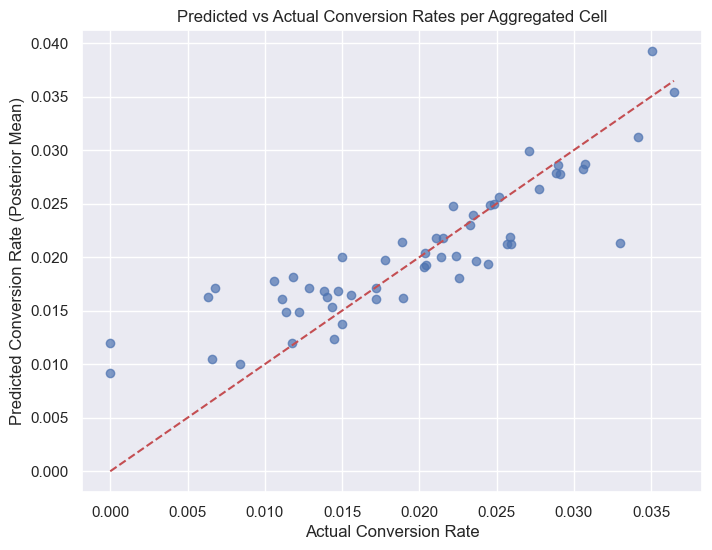

R-squared between predicted and actual conversion rates: 0.74394
Mean Squared Error: 0.0000179


In [28]:
# Extract mean predicted conversion rate per cell (posterior mean)
predicted_k_mean = posterior_pred.mean(dim=('chain', 'draw'))  # mean over draws
predicted_p_mean = predicted_k_mean.obs.values / agg_data["n"].values  # predicted conversion rate

# Actual conversion rate
actual_p = agg_data["k"].values / agg_data["n"].values

# Create a DataFrame for comparison
df_compare = pd.DataFrame({
    "predicted_conversion_rate": predicted_p_mean,
    "actual_conversion_rate": actual_p,
    "group": agg_data["test_group"],
    "day": agg_data["most_ads_day"],
    "section": agg_data["section"]
})

# Plot predicted vs actual conversion rates
plt.figure(figsize=(8, 6))
plt.scatter(df_compare["actual_conversion_rate"], df_compare["predicted_conversion_rate"], alpha=0.7)
plt.plot([0, df_compare["actual_conversion_rate"].max()], [0, df_compare["actual_conversion_rate"].max()], 'r--')
plt.xlabel("Actual Conversion Rate")
plt.ylabel("Predicted Conversion Rate (Posterior Mean)")
plt.title("Predicted vs Actual Conversion Rates per Aggregated Cell")
plt.grid(True)
plt.show()

# Optionally, summary statistics on predictive performance
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(df_compare["actual_conversion_rate"], df_compare["predicted_conversion_rate"])
mse = mean_squared_error(df_compare["actual_conversion_rate"], df_compare["predicted_conversion_rate"])

print(f"R-squared between predicted and actual conversion rates: {r2:.5f}")
print(f"Mean Squared Error: {mse:.7f}")


## Checking if the model confirms preliminary findings <a class="anchor" id="checking_if_the"></a>


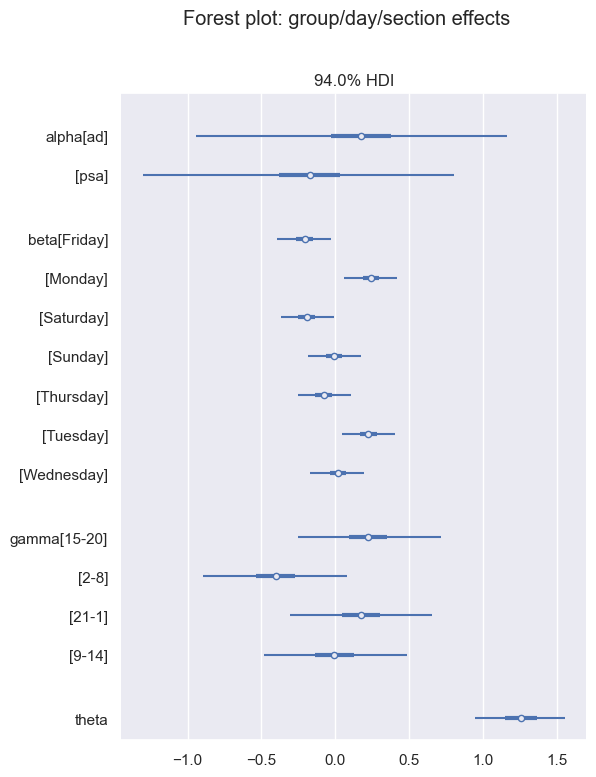

In [29]:
# 4. Forest plot for hierarchical group partial pooling visualization
az.plot_forest(idata_model_tmp, var_names=["alpha", "beta", "gamma", "theta"], combined=True)
plt.suptitle("Forest plot: group/day/section effects")
plt.show()

In [30]:
with model:
    ppc = pm.sample_posterior_predictive(idata_model_tmp, var_names=["obs"])


Sampling: [obs]


/usr/local/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


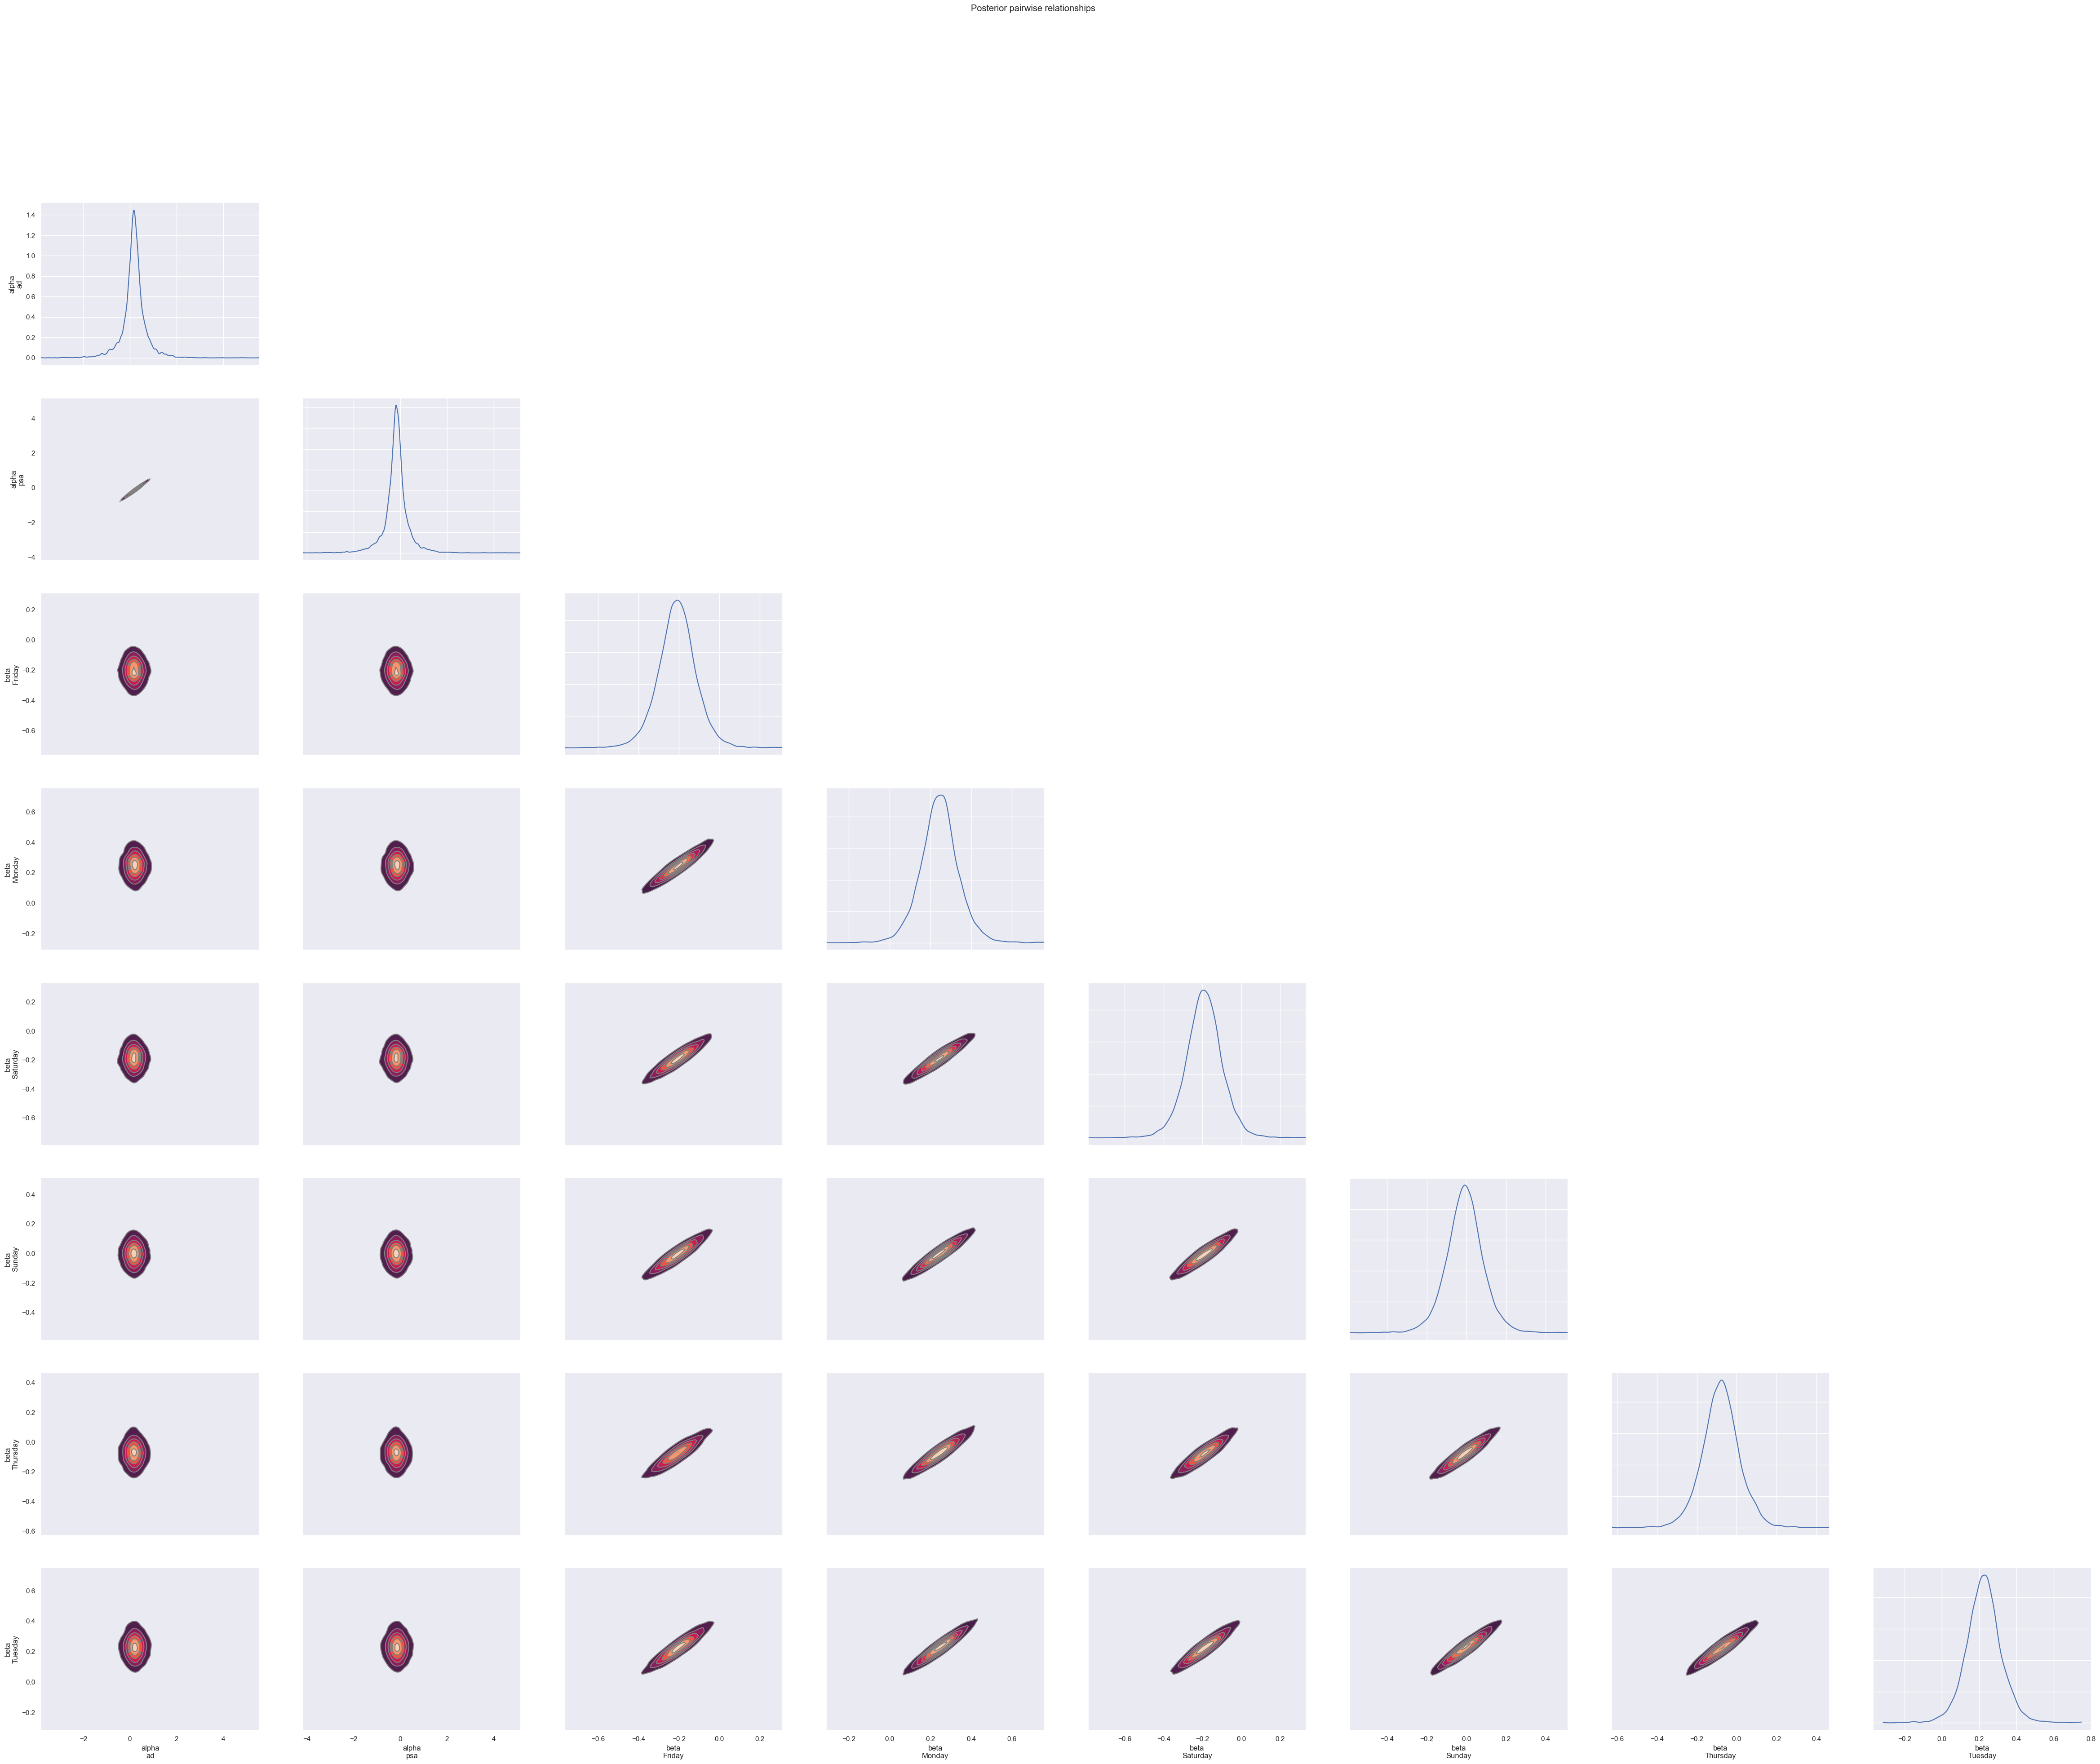

In [31]:
# 1. pairwise parameter correlations to detect dependencies
az.plot_pair(idata_model_tmp, var_names=["alpha", "beta", "gamma", "theta"], kind="kde", marginals=True)
plt.suptitle("Posterior pairwise relationships")
plt.show()

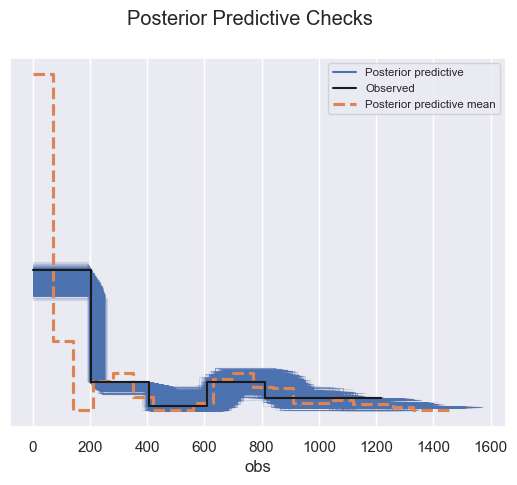

In [32]:


# 2. Posterior predictive checks (if available)
az.plot_ppc(ppc)
plt.suptitle("Posterior Predictive Checks")
plt.show()



## Which combination `(group, day, section)` has highest convertion rate? <a class="anchor" id="which_combination_`(group,"></a>

Below we plot this for top 10 most effective combinations

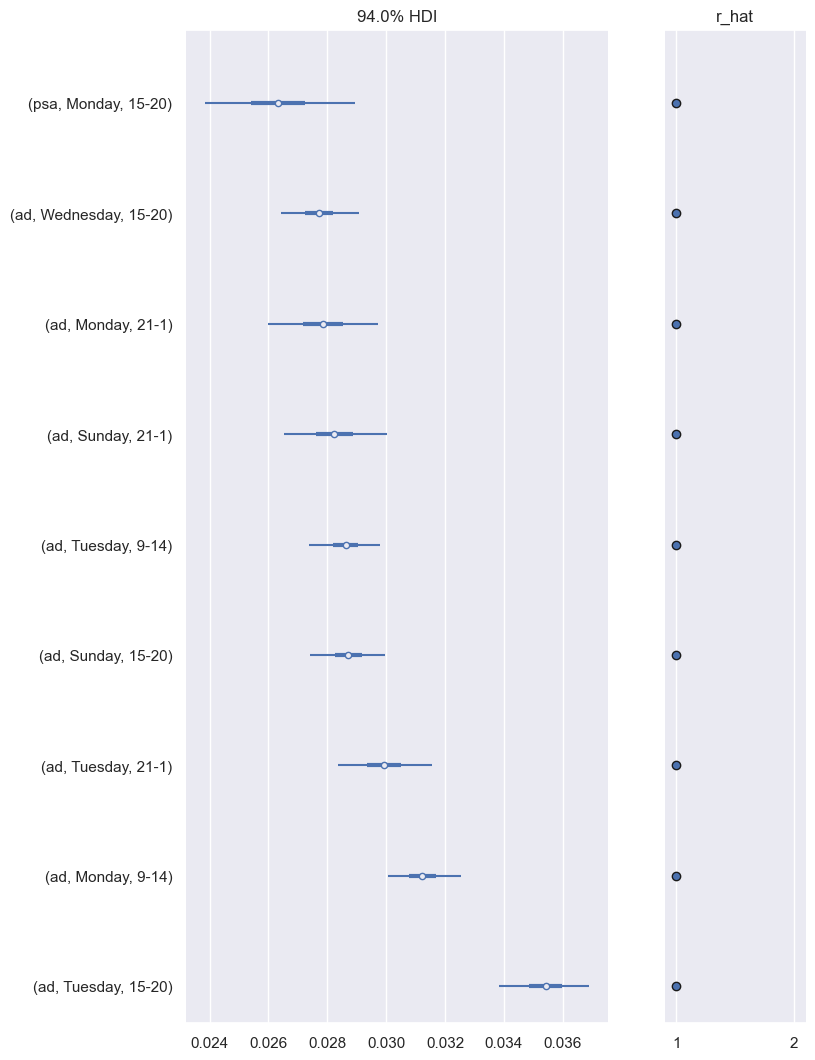

In [127]:
predicted_k_mean = posterior_pred.mean(dim=('chain', 'draw'))  # mean over draws
predicted_p_mean = predicted_k_mean.obs.values / agg_data["n"].values 
high_p_cells = (np.argsort(predicted_p_mean))[-10:-1] # getting top 10 maximum p values 
# posterior variables from InferenceData for plotting
posterior_vars = { f"({agg_data.loc[i,'test_group']}, {agg_data.loc[i,'most_ads_day']}, {agg_data.loc[i,'section']})" : idata_model_tmp.posterior["p"].sel(p_dim_0=i) for i in high_p_cells
}

# Plot forest with all chains combined (default)
az.plot_forest(posterior_vars, combined=True, r_hat=True)
plt.show()


array([<AxesSubplot: title={'center': '94.0% HDI'}>,
       <AxesSubplot: title={'center': 'r_hat'}>], dtype=object)

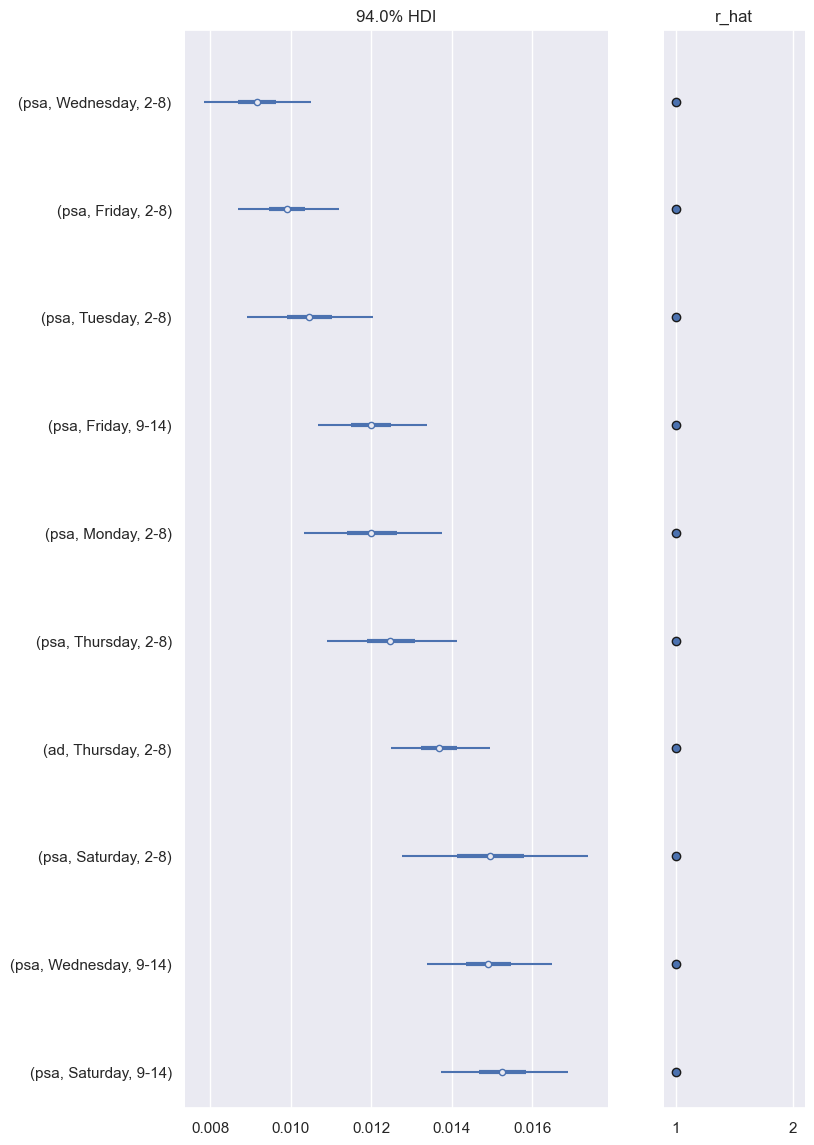

In [104]:
predicted_k_mean = posterior_pred.mean(dim=('chain', 'draw'))  # mean over draws
predicted_p_mean = predicted_k_mean.obs.values / agg_data["n"].values 
high_p_cells = (np.argsort(predicted_p_mean))[:10] # getting bottom 10 p values 
# posterior variables from InferenceData for plotting
posterior_vars = { f"({agg_data.loc[i,'test_group']}, {agg_data.loc[i,'most_ads_day']}, {agg_data.loc[i,'section']})" : idata_model_tmp.posterior["p"].sel(p_dim_0=i) for i in high_p_cells
}

# Plot forest with all chains combined (default)
az.plot_forest(posterior_vars, combined=True, r_hat=True)

## Conclusions <a class="anchor" id="conclusions"></a>

1. Bayesian analysis confirms the influence of `total ads`, the day with most ads shown and the hour with most ads shown, all significantly affect conversion rates -- confirming the key drivers found in the preliminary analysis
2. By modeling the full posterior distributions for every combination of group, day, and time section, we identified which slots and user segments have statistically credible, strong effects, moving beyond simple point estimates. 
3. Posterior checks showed a good match between model predictions and actual data, suggesting the model captured the main features of the data well. 
4. <p>If the marketing team seeks optimal advertising times, our analysis highlights the following prime slots:  <span style="background-color: yellow;"> Tuesday evenings (15–23), Monday mornings (9–14), and Sunday afternoons (15–20) as the most effective windows for conversion.</span></p>
5. <p>From the posterior distribution of `beta[day]`, <span style="background-color: yellow;"> conversion rates are notably lower on Friday and Saturday </span>compared to Monday, Tuesday, and Sunday--suggesting these days are least suitable for ad campaigns. </p> 
6. For future analysis, incorporating explicit interactions between `most_ads_day` and `test_group`,  and  `section` and `test_group` could reveal deeper group-dependent timing effects and optimize targeting strategies. Further, the model can be improved account for full ad exposure distribution than just mean value of the particular combination (group, day, section)
7. The hierarchical Bayesian approach also improves reliability for small subgroups, allowing robust insights even with limited data in less popular slots.

## Interaction Model <a class="anchor" id="interaction_model"></a>


### Model discription <a class="anchor" id="model_discription_0"></a>
Only difference compared to earlier (interaction free) model is including interaction of group with day and section

$$ z_i = \alpha^{group[i]} + \mathbf{\beta^{day[i], group[i]}} + \mathbf{\gamma^{section[i], group[i]}} + \theta * x_i$$




In [105]:
# COORDS definition based on unique group/day/section
COORDS = {
    "group": unique_groups,
    "day": unique_days,
    "section": unique_sections,
    "cell": np.arange(len(agg_data)),
}

with pm.Model(coords=COORDS) as model_interaction:
    # Hyperpriors for group/day/section effects
    sigma_group = pm.HalfNormal("sigma_group", 1)
    sigma_day = pm.HalfNormal("sigma_day", 1)
    sigma_section = pm.HalfNormal("sigma_section", 1)

    # Partial pooling of intercepts    
    mu_base = pm.Normal("mu_base", mu=0, sigma=50)
    sigma_base = pm.HalfNormal("sigma_base", sigma=10)
    delta = pm.Normal("delta", mu=mu_base, sigma=sigma_base)
    alpha = pm.Normal("alpha", mu=0, sigma=sigma_group, dims="group")
    beta = pm.Normal("beta", mu=0, sigma=sigma_day, dims=("day", "group")) # introducing interaction day & group
    gamma = pm.Normal("gamma", mu=0, sigma=sigma_section, dims=("section","group")) # introducing interaction b/w section & group

    # Regression coefficient for mean total_ads (continuous)
    theta = pm.Normal("theta", mu=0, sigma=1)

    # Data inputs aligned with cells
    group_idx = pm.Data("group_idx", agg_data["group_idx"], dims="cell")
    day_idx = pm.Data("day_idx", agg_data["day_idx"], dims="cell")
    section_idx = pm.Data("section_idx", agg_data["section_idx"], dims="cell")
    n = pm.Data("n", agg_data["n"], dims="cell")  # total users per cell
    k = pm.Data("k", agg_data["k"], dims="cell")  # conversions per cell
    mean_ads = pm.Data("mean_ads", agg_data["mean_total_ads"], dims="cell")

    # Linear model for logit of conversion probability
    logit_p = (
        delta
        + alpha[group_idx]
        + beta[day_idx, group_idx]
        + gamma[section_idx, group_idx]
        + theta * pm.math.log(1 + mean_ads)
    )

    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

    # Binomial likelihood
    obs = pm.Binomial("obs", n=n, p=p, observed=k, dims="cell")
    
    idata_model_interaction = pm.sample(tune=1000, draws=2000, chains=5, return_inferencedata=True)


/usr/local/lib/python3.9/site-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 2 jobs)
NUTS: [sigma_group, sigma_day, sigma_section, mu_base, sigma_base, delta, alpha, beta, gamma, theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS 

Sampling 5 chains for 1_000 tune and 2_000 draw iterations (5_000 + 10_000 draws total) took 2212 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.


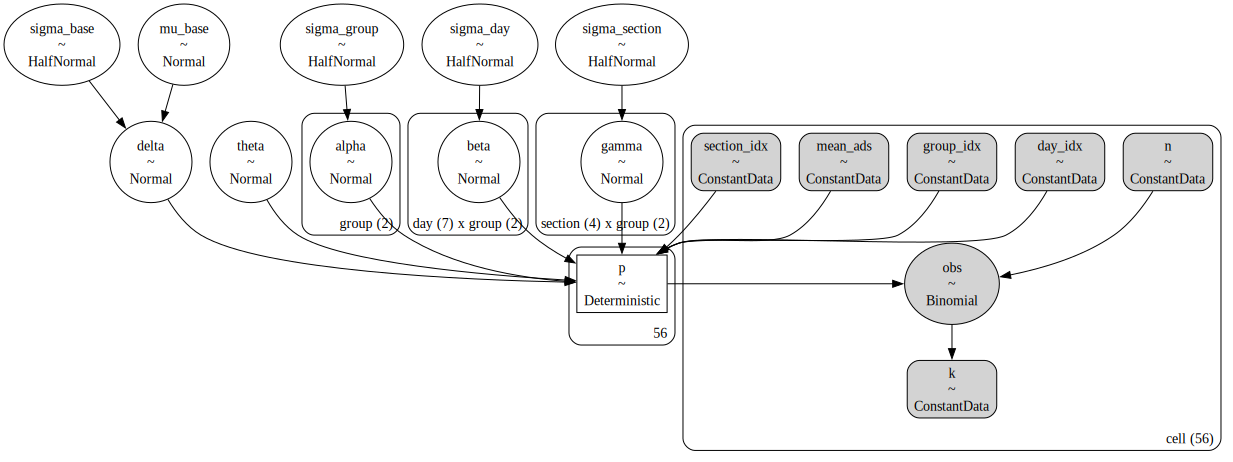

In [130]:
pm.model_to_graphviz(model_interaction)


Sampling: [obs]


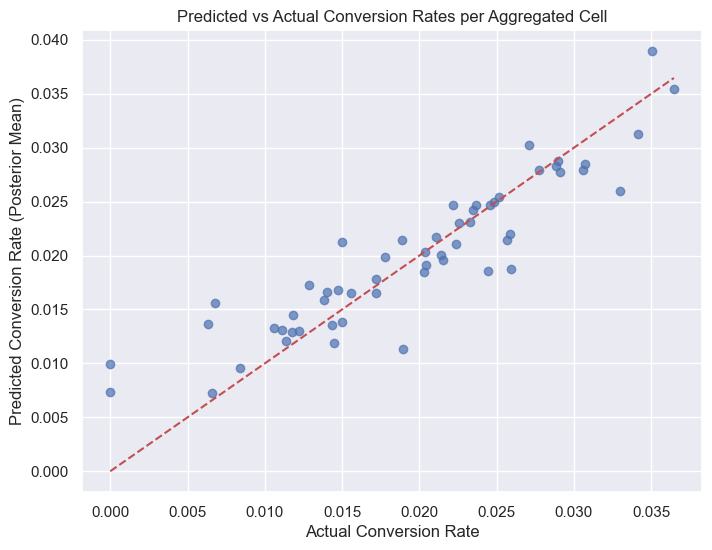

R-squared between predicted and actual conversion rates: 0.82113
Mean Squared Error: 0.0000125


In [107]:
# Generate posterior predictive samples
with model_interaction:
    posterior_pred_int = pm.sample_posterior_predictive(idata_model_interaction, predictions=True).predictions
    
# Extract mean predicted conversion rate per cell (posterior mean)
predicted_k_mean = posterior_pred_int.mean(dim=('chain', 'draw'))  # mean over draws
predicted_p_mean = predicted_k_mean.obs.values / agg_data["n"].values  # predicted conversion rate

# Actual conversion rate
actual_p = agg_data["k"].values / agg_data["n"].values

# Create a DataFrame for comparison
df_compare = pd.DataFrame({
    "predicted_conversion_rate": predicted_p_mean,
    "actual_conversion_rate": actual_p,
    "group": agg_data["test_group"],
    "day": agg_data["most_ads_day"],
    "section": agg_data["section"]
})

# Plot predicted vs actual conversion rates
plt.figure(figsize=(8, 6))
plt.scatter(df_compare["actual_conversion_rate"], df_compare["predicted_conversion_rate"], alpha=0.7)
plt.plot([0, df_compare["actual_conversion_rate"].max()], [0, df_compare["actual_conversion_rate"].max()], 'r--')
plt.xlabel("Actual Conversion Rate")
plt.ylabel("Predicted Conversion Rate (Posterior Mean)")
plt.title("Predicted vs Actual Conversion Rates per Aggregated Cell")
plt.grid(True)
plt.show()

# Optionally, summary statistics on predictive performance
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(df_compare["actual_conversion_rate"], df_compare["predicted_conversion_rate"])
mse = mean_squared_error(df_compare["actual_conversion_rate"], df_compare["predicted_conversion_rate"])

print(f"R-squared between predicted and actual conversion rates: {r2:.5f}")
print(f"Mean Squared Error: {mse:.7f}")


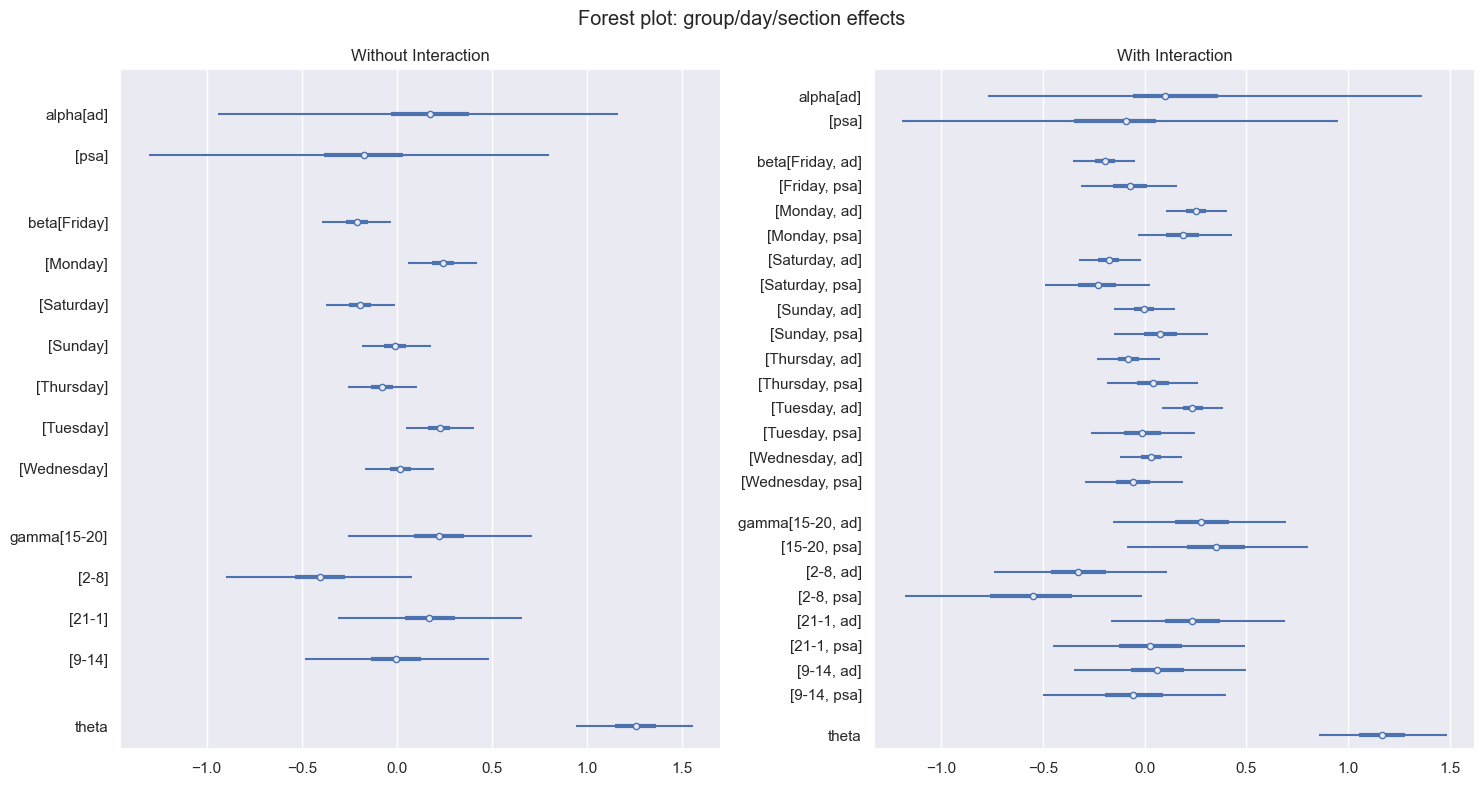

In [120]:
# 4. Forest plot for hierarchical group partial pooling visualization

figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
az.plot_forest(idata_model_tmp, var_names=["alpha", "beta", "gamma", "theta"], combined=True,
              ax=axes[0])
axes[0].set_title('Without Interaction')

az.plot_forest(idata_model_interaction, var_names=["alpha", "beta", "gamma", "theta"], combined=True,
              ax=axes[1])
axes[1].set_title('With Interaction')
plt.suptitle("Forest plot: group/day/section effects")
plt.tight_layout()
plt.show()

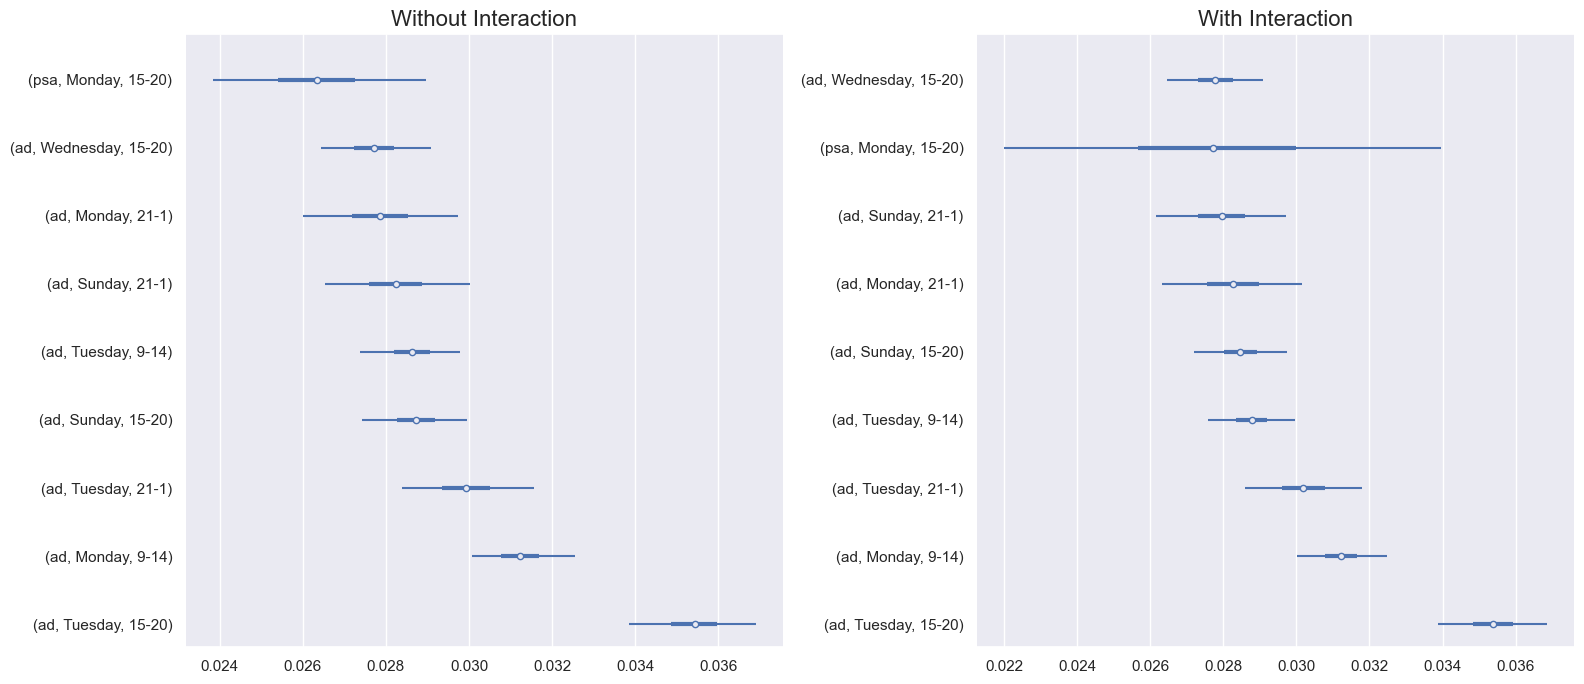

In [118]:

figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

# Plot forest with all chains combined (default)
predicted_k_mean = posterior_pred.mean(dim=('chain', 'draw'))  # mean over draws
predicted_p_mean = predicted_k_mean.obs.values / agg_data["n"].values 
high_p_cells = (np.argsort(predicted_p_mean))[-10:-1] # getting top 10 maximum p values 
# posterior variables from InferenceData for plotting
posterior_vars = { f"({agg_data.loc[i,'test_group']}, {agg_data.loc[i,'most_ads_day']}, {agg_data.loc[i,'section']})" : idata_model_tmp.posterior["p"].sel(p_dim_0=i) for i in high_p_cells
}


az.plot_forest(posterior_vars, combined=True, ax=axes[0])

predicted_k_mean = posterior_pred_int.mean(dim=('chain', 'draw'))  # mean over draws
predicted_p_mean = predicted_k_mean.obs.values / agg_data["n"].values 
high_p_cells = (np.argsort(predicted_p_mean))[-10:-1] # getting top 10 maximum p values 
# posterior variables from InferenceData for plotting
posterior_vars = { f"({agg_data.loc[i,'test_group']}, {agg_data.loc[i,'most_ads_day']}, {agg_data.loc[i,'section']})" : idata_model_interaction.posterior["p"].sel(p_dim_0=i) for i in high_p_cells
}

# Plot forest with all chains combined (default)
az.plot_forest(posterior_vars, combined=True,  ax=axes[1])

axes[0].set_title("Without Interaction", fontsize=16)
axes[1].set_title("With Interaction", fontsize=16)
plt.tight_layout()
plt.show()


# Conclusions <a class="anchor" id="conclusions_0"></a>


## Interaction Free <a class="anchor" id="interaction_free"></a>
1. Bayesian analysis confirms the influence of `total ads`, the day with most ads shown and the hour with most ads shown, all significantly affect conversion rates -- confirming the key drivers found in the preliminary analysis.
2. The hierarchical Bayesian approach also improves reliability for small subgroups, allowing robust insights even with limited data in less popular slots.
3. By modeling the full posterior distributions for every combination of group, day, and time section, we identified which slots and user segments have statistically credible, strong effects, moving beyond simple point estimates. 
4. Posterior checks showed a good match between model predictions and actual data, suggesting the model captured the main features of the data well. 
5. <p>If the marketing team seeks optimal advertising times, our analysis highlights the following prime slots:  <span style="background-color: yellow;"> Tuesday evenings (15–23), Monday mornings (9–14), and Sunday afternoons (15–20) as the most effective windows for conversion.</span></p>
6. <p>From the posterior distribution of `beta[day]`, <span style="background-color: yellow;"> conversion rates are notably lower on Friday and Saturday </span>compared to Monday, Tuesday, and Sunday--suggesting these days are least suitable for ad campaigns. </p> 



## Interaction <a class="anchor" id="interaction"></a>
1. The interaction model fits the data better (R² = 0.82 vs. 0.74) and reveals more nuanced group-day-section effects, allowing for more precise campaign targeting and robust insights even for small or sparse subgroups
2. Further, the model can be improved account for full ad exposure distribution than just mean value of the particular combination (group, day, section)